# Задание 3. Диффузия

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## 3.1 Формула Грина-Кубо

In [42]:
dt = 0.001

In [43]:
def get_init(T: str):
    path = f'dump_T{T}/0.xyz'
    number_of_particles = int(open(path).readline())
    box_size = float(open(path).readlines()[1].split()[1])
    return number_of_particles, box_size

In [44]:
def get_xyz(T: str, start_time: float, duration: float):
    start_frame = start_time / dt
    end_frame = (start_time + duration) / dt
    paths = [f'dump_T{T}/{i}.xyz' for i in np.arange(start_frame, end_frame, 1).astype(int)]

    xyz = [pd.DataFrame([line.split()
                        for line in open(path).readlines()[2:]]).drop(labels=[0, 1, 2], axis=1)
                        for path in paths]

    for df in xyz: df.columns = ['vx', 'vy', 'vz']

    return xyz

In [45]:
def vacf(vel: np.array, duration: float, step: int):
    len = int(duration / dt)
    velcor = np.zeros(len)
    dot = np.zeros(vel.shape[1])
    amp = np.zeros(vel.shape[1])

    counter = 0
    for start in np.arange(0, (vel.shape[0] - len), step):
        for frame in range(len):
            for n in range(vel.shape[1]):
                dot[n] = np.dot(vel[start][n], vel[start + frame][n])
                amp[n] = np.linalg.norm(np.array(vel[frame + start][n]))

            velcor[frame] += np.mean(dot) / np.mean(amp*amp)
        counter += 1
    
    velcor /= counter

    return velcor

In [46]:
number_of_particles, box_size = get_init(1.0)

In [47]:
T = [1.0, 1.5, 2.0]

In [48]:
xyz = defaultdict(list)

for t in T:
    xyz[t] = (get_xyz(T=t, start_time=5.0, duration=5.0))

In [49]:
vel = defaultdict(list)

for t in T:
    vel[t] = (np.array([[xyz[t][frame].iloc[n].to_numpy().astype(float)
                            for n in range(number_of_particles)]
                            for frame in range(len(xyz[t]))]))

In [66]:
diffusion = defaultdict(float)
vacf_duration = 4.00

for t in T:
    y = vacf(vel[t], duration=vacf_duration, step=100)
    x = np.linspace(0, vacf_duration, int(vacf_duration/dt))
    diffusion[t] = (t * np.trapz(y, x))

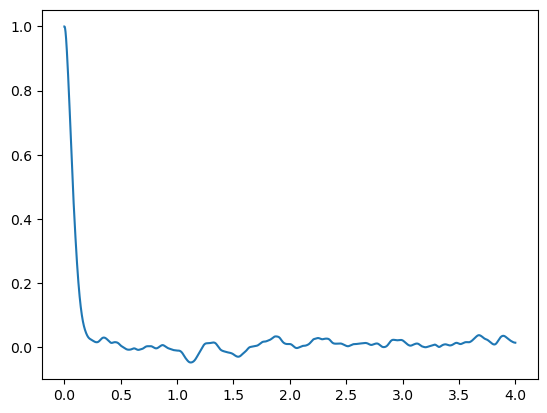

In [67]:
plt.plot(x, y)

In [69]:
diffusion

defaultdict(float,
            {1.0: 0.07273248689210832,
             1.5: 0.12944522898347297,
             2.0: 0.22953650444675366})

## 3.2 Формула Эйнштейна

In [52]:
msd = defaultdict(list)

for t in T:
    path = f"thermo{t}"
    msd[t] = np.array([open(path).readlines()[4:][i].split(' ')[9] for i in np.arange(5000, 10000)]).astype(float)

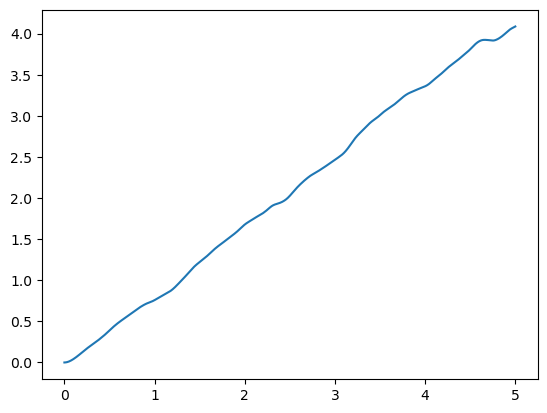

In [53]:
plt.plot(np.linspace(0, 5.0, 5000), msd[1.5])

In [70]:
x = np.linspace(0, 5.0, 5000)

diffusion_einstein = defaultdict(float)

for t in T:
    diffusion_einstein[t] = np.polyfit(x, msd[t], 1)[0] / 6

diffusion_einstein

defaultdict(float,
            {1.0: 0.10089475796611565,
             1.5: 0.14210635247907707,
             2.0: 0.16771372762635187})

## 3. Сравнение

In [73]:
diffusion_target = [0.105, 0.156, 0.217]

In [96]:
pd.DataFrame(columns=["Грин-Кубо", "Эйнштейн", "Rowley and Painter"], index=[1.0, 1.5, 2.0],
             data = np.array([list(diffusion.values()), list(diffusion_einstein.values()), list(diffusion_target)]).T.round(3))

,Грин-Кубо,Эйнштейн,Rowley and Painter
1.0,0.073,0.101,0.105
1.5,0.129,0.142,0.156
2.0,0.230,0.168,0.217
